In [30]:
import numpy as np # para operações
import matplotlib.pyplot as plt # para plotagem
import seaborn as sns # para plotagem
import pandas as pd # para algumas poucas manipulações
from scipy.stats import mode # pegar a moda
from itertools import product # fazer o grid dos parâmetros
from ast import literal_eval # string to dict

# Questão 1

Considere o conjunto de dados disponível em `kc2.csv`, organizado em 22 colunas, sendo as 21 primeiras colunas os atributos e a última coluna a saída. 

Os 21 atributos são referentes à caracterização de códigos-fontes para processamento de dados na NASA. A saída é a indicação de ausência (`0`) ou existência (`1`) de defeitos (os dados foram balanceados via subamostragem).

Maiores detalhes sobre os dados podem ser conferidos em:  
[https://www.openml.org/search?type=data&sort=runs&id=1063&status=active](https://www.openml.org/search?type=data&sort=runs&id=1063&status=active)


In [31]:
class StandardScaler:
    """
    Classe para padronizar usando z-score
    """

    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, ddof=1, axis=0)

    def fit_transform(self, X):
        self.fit(X)
        return (X - self.mean) / self.std

    def transform(self, X):
        return (X - self.mean) / self.std

    def inverse(self, X):
        return X * self.std + self.mean

In [32]:
def calc_acuracia_global(y, y_hat):
    """
    Calcular a acurácia global
    """
    return np.mean(y == y_hat)


def calc_acuracia_classe(y, y_hat):
    """
    Calcular a acurácia por classe
    """
    classes = np.unique(y)
    acuracia_por_classe = {}

    for classe in classes:
        idx_classe = y == classe
        acuracia = np.mean(y_hat[idx_classe] == y[idx_classe])
        acuracia_por_classe[int(classe)] = acuracia

    return acuracia_por_classe


def matriz_confusao(y, y_hat):
    """
    Calcular a matriz de confusão
    """
    classes = np.unique(y)
    n_classes = len(classes)
    matriz = np.zeros((n_classes, n_classes), dtype=int)

    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            matriz[i, j] = np.sum((y == true_class) & (y_hat == pred_class))
    return matriz


def calc_revocacao(y, y_hat):
    """
    Revocação é uma métrica usada em classificação binária para medir
    quantos dos casos positivos reais o modelo conseguiu identificar corretamente
    """
    verdadeiros_positivos = np.sum((y == 1) & (y_hat == 1))
    falsos_negativos = np.sum((y == 1) & (y_hat == 0))
    denominador = verdadeiros_positivos + falsos_negativos
    if denominador == 0:
        return 0.0
    return verdadeiros_positivos / denominador


def calc_precisao(y, y_hat):
    """
    A precisão mede quantas das previsões positivas feitas pelo modelo estavam corretas.
    """
    verdadeiros_positivos = np.sum((y == 1) & (y_hat == 1))
    falsos_positivos = np.sum((y == 0) & (y_hat == 1))
    denominador = verdadeiros_positivos + falsos_positivos
    if denominador == 0:
        return 0.0
    return verdadeiros_positivos / denominador


def calc_f1_score(y, y_hat):
    """
    O F1-score é a média harmônica entre a precisão e a revocação
    """
    verdadeiros_positivos = np.sum((y == 1) & (y_hat == 1))
    falsos_negativos = np.sum((y == 1) & (y_hat == 0))
    falsos_positivos = np.sum((y == 0) & (y_hat == 1))
    denominador = 2 * verdadeiros_positivos + falsos_negativos + falsos_positivos
    if denominador == 0:
        return 0.0
    return 2 * verdadeiros_positivos / denominador

In [33]:
class GridSearchCV:
    """
    kfold: Número de folds para a validação cruzada.
    seed: Valor da semente para garantir reprodutibilidade dos resultados.
    standard: Indica se as variáveis devem ser padronizadas (z-score normalization).
    parametros: Dicionário contendo os parâmetros do modelo a serem avaliados no Grid Search.
    """

    def __init__(self, modelo, kfold=10, seed=None, standard=True, parametros={}):
        self.modelo = modelo
        self.parametros = parametros
        self.kfold = kfold
        self.seed = seed
        self.metricas = []
        self.standard = standard

    def fit(self, X, y):
        self.metricas = []
        random_generator = np.random.default_rng(seed=self.seed)
        size_sample = int(len(X) / self.kfold)
        indexes = np.arange(len(X))
        random_generator.shuffle(indexes)

        chaves = list(self.parametros.keys())
        valores = list(self.parametros.values())

        combinacoes = [
            dict(zip(chaves, v)) for v in product(*valores)
        ]  # Todas as combinações possíveis de parâmetros

        for parametro in combinacoes:
            print("=" * 90)
            print(f"{parametro}")

            for i in range(self.kfold):
                print(f"k = {i + 1}/{self.kfold}")

                test_indexes = indexes[i * size_sample : (i + 1) * size_sample]
                train_indexes = np.concatenate(
                    (indexes[: i * size_sample], indexes[(i + 1) * size_sample :])
                )

                fit_model = self.modelo(**parametro)

                if self.standard:
                    X_std = StandardScaler()
                    X_train = X_std.fit_transform(X[train_indexes])
                    X_test = X_std.transform(X[test_indexes])
                else:
                    X_train = X[train_indexes]
                    X_test = X[test_indexes]

                fit_model.fit(X_train, y[train_indexes])

                y_test_hat = fit_model.predict(X_test).ravel()

                # Calcular as métricas
                acuracia = calc_acuracia_global(y[test_indexes].ravel(), y_test_hat)
                acuracia_classe = calc_acuracia_classe(
                    y[test_indexes].ravel(), y_test_hat
                )
                revocacao = calc_revocacao(y[test_indexes].ravel(), y_test_hat)
                precisao = calc_precisao(y[test_indexes].ravel(), y_test_hat)
                f1_score = calc_f1_score(y[test_indexes].ravel(), y_test_hat)
                matriz_conf = matriz_confusao(y[test_indexes].ravel(), y_test_hat)

                print("Matriz de confusão:")
                print(matriz_conf)
                print(f"Acurácia: {acuracia}")
                print(f"Acurácia classe: {acuracia_classe}")
                print(f"Revocação: {revocacao}")
                print(f"Precisão: {precisao}")
                print(f"F1-score: {f1_score}")

                print("-" * 90)

                self.metricas.append(
                    {
                        "parametros": str(parametro),
                        "acuracia": acuracia,
                        "revocacao": revocacao,
                        "precisao": precisao,
                        "f1_score": f1_score,
                    }
                )

    def data_frame(self):
        """
        Métricas em um dataframe longo
        """
        return pd.DataFrame(self.metricas).melt(
            id_vars="parametros", var_name="metricas"
        )

    def _highlight_max_mean(self, s):
        is_mean_col = s.name.endswith("_mean")
        if is_mean_col:
            return [
                "background-color: lightgreen; color: black" if v == s.max() else ""
                for v in s
            ]
        return [""] * len(s)

    def summary(self):
        """
        Retorna as métricas em um DataFrame no formato largo.

        Cada métrica é representada por duas colunas:
        uma para a média e outra para o desvio padrão.

        - Colunas: <nome_da_métrica>_mean, <nome_da_métrica>_std
        """
        tabela = self.data_frame()
        tabela = (
            tabela.groupby(["parametros", "metricas"])["value"]
            .agg(["mean", "std"])
            .reset_index()
            .pivot(index="parametros", columns="metricas")
        )

        tabela = tabela.swaplevel(axis=1)

        tabela = tabela.sort_index(axis=1, level=0)

        tabela.columns = [f"{metrica}_{agg}" for metrica, agg in tabela.columns]

        return (
            tabela.style.format(precision=2)
            .set_caption(
                f"Resumo dos Resultados do Grid Search - {self.modelo().__class__.__name__}"
            )
            .apply(self._highlight_max_mean, axis=0)
            .set_properties(**{"text-align": "center"})
        )

    def best_param(self):
        """
        Melhores parâmetros do modelo com base na acurácia
        """
        return literal_eval(self.summary()["acuracia_mean"].idxmax())

    def best_model(self):
        """
        Melhor modelo com base na acurácia
        """
        return self.modelo(**self.best_param())

In [34]:
class KNN:
    """
    Modelo KNN (K-Nearest Neighbors)

    - k: número de vizinhos a serem considerados na classificação.
    - dist: métrica de distância utilizada. Pode ser 'euclidiana' ou 'mahalanobis'.
    """

    def __init__(self, k=1, dist="euclidiana"):
        self.X_train = None
        self.y_train = None
        self.k = k
        self.dist = dist

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X):
        if self.dist == "euclidiana":
            dists = (
                -2 * (X @ self.X_train.T)
                + (X**2).sum(axis=1, keepdims=True)
                + (self.X_train**2).sum(axis=1)
            )

        elif self.dist == "mahalanobis":
            dists = np.zeros((X.shape[0], self.X_train.shape[0]))
            cov = np.cov(self.X_train.T)
            inv_cov = np.linalg.inv(cov)

            for i in range(X.shape[0]):
                for j in range(self.X_train.shape[0]):
                    diff = X[i] - self.X_train[j]
                    dists[i, j] = np.sqrt(diff.T @ inv_cov @ diff)

        else:
            print("Use euclidiana ou mahalanobis")
            return None

        k_mais_proximos = np.argsort(dists, axis=1)[:, : self.k]
        vizinhos = self.y_train[k_mais_proximos]
        y_pred, _ = mode(vizinhos, axis=1, keepdims=False)
        return y_pred

In [35]:
data = np.genfromtxt('kc2.csv', delimiter=',')

In [36]:
data

array([[ 4.,  1.,  1., ...,  1.,  1.,  0.],
       [39.,  4.,  1., ..., 44.,  7.,  0.],
       [ 1.,  1.,  1., ...,  1.,  1.,  0.],
       ...,
       [ 4.,  1.,  1., ...,  1.,  1.,  1.],
       [ 4.,  1.,  1., ...,  2.,  1.,  1.],
       [ 3.,  1.,  1., ...,  0.,  1.,  1.]], shape=(214, 22))

In [37]:
data.shape

(214, 22)

In [38]:
X = data[:,0:21]

In [39]:
y = data[:,21]

In [40]:
X.shape

(214, 21)

In [41]:
y = y.reshape(-1,1)

In [42]:
y.shape

(214, 1)

In [43]:
# Distribuição do y nos dados
classes, counts = np.unique(y, return_counts=True)
{int(key): value for key, value in zip(classes, counts / np.sum(counts))}

{0: np.float64(0.5), 1: np.float64(0.5)}

## a) Considerando uma validação cruzada em 10 folds, avalie modelos de classificação binária nos dados em questão. Para tanto, use as abordagens abaixo:

- **KNN** (escolha `k = 1` e `k = 5`, com distância Euclidiana e Mahalanobis, totalizando 4 combinações);

- **Árvore de decisão** (você pode usar uma implementação já existente, como a do `scikit-learn`, com índices de impureza de *gini* e *entropia*).


In [44]:
GridSearchCV?

Init signature: GridSearchCV(modelo, kfold=10, seed=None, standard=True, parametros={})
Docstring:     
kfold: Número de folds para a validação cruzada.
seed: Valor da semente para garantir reprodutibilidade dos resultados.
standard: Indica se as variáveis devem ser padronizadas (z-score normalization).
parametros: Dicionário contendo os parâmetros do modelo a serem avaliados no Grid Search.
Type:           type
Subclasses:     

In [45]:
# O modelo KNN já foi definido acima, assim como o GridSearchCV. 
# Este último também realiza a padronização dos dados, utilizando as métricas do conjunto de treino em cada iteração.

knn_grid = GridSearchCV(
    modelo=KNN,
    parametros={"k": [1, 5], "dist": ["euclidiana", "mahalanobis"]},
    kfold=10,
    seed=1,
    standard=True,
)

In [46]:
knn_grid.fit(X,y)

{'k': 1, 'dist': 'euclidiana'}
k = 1/10
Matriz de confusão:
[[9 8]
 [0 4]]
Acurácia: 0.6190476190476191
Acurácia classe: {0: np.float64(0.5294117647058824), 1: np.float64(1.0)}
Revocação: 1.0
Precisão: 0.3333333333333333
F1-score: 0.5
------------------------------------------------------------------------------------------
k = 2/10
Matriz de confusão:
[[ 7  0]
 [ 4 10]]
Acurácia: 0.8095238095238095
Acurácia classe: {0: np.float64(1.0), 1: np.float64(0.7142857142857143)}
Revocação: 0.7142857142857143
Precisão: 1.0
F1-score: 0.8333333333333334
------------------------------------------------------------------------------------------
k = 3/10
Matriz de confusão:
[[9 3]
 [0 9]]
Acurácia: 0.8571428571428571
Acurácia classe: {0: np.float64(0.75), 1: np.float64(1.0)}
Revocação: 1.0
Precisão: 0.75
F1-score: 0.8571428571428571
------------------------------------------------------------------------------------------
k = 4/10
Matriz de confusão:
[[10  0]
 [ 2  9]]
Acurácia: 0.9047619047619048
A

In [47]:
from sklearn.tree import DecisionTreeClassifier # Useia a implementação da árvore de decisão do sklearn

In [48]:
dt_grid = GridSearchCV(
    DecisionTreeClassifier,
    parametros={
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 3],
        "random_state": [0],
    },
    kfold=10,
    seed=1,
    standard=False,
)

In [49]:
dt_grid.fit(X,y)

{'criterion': 'gini', 'max_depth': None, 'random_state': 0}
k = 1/10
Matriz de confusão:
[[11  6]
 [ 0  4]]
Acurácia: 0.7142857142857143
Acurácia classe: {0: np.float64(0.6470588235294118), 1: np.float64(1.0)}
Revocação: 1.0
Precisão: 0.4
F1-score: 0.5714285714285714
------------------------------------------------------------------------------------------
k = 2/10
Matriz de confusão:
[[ 6  1]
 [ 4 10]]
Acurácia: 0.7619047619047619
Acurácia classe: {0: np.float64(0.8571428571428571), 1: np.float64(0.7142857142857143)}
Revocação: 0.7142857142857143
Precisão: 0.9090909090909091
F1-score: 0.8
------------------------------------------------------------------------------------------
k = 3/10
Matriz de confusão:
[[11  1]
 [ 2  7]]
Acurácia: 0.8571428571428571
Acurácia classe: {0: np.float64(0.9166666666666666), 1: np.float64(0.7777777777777778)}
Revocação: 0.7777777777777778
Precisão: 0.875
F1-score: 0.8235294117647058
------------------------------------------------------------------------

## b) Para cada modelo criado, reporte o valor médio e o desvio padrão das métricas de **acurácia**, **revocação**, **precisão** e **F1-score**.


In [50]:
knn_grid.summary()

,acuracia_mean,acuracia_std,f1_score_mean,f1_score_std,precisao_mean,precisao_std,revocacao_mean,revocacao_std
parametros,,,,,,,,
"{'k': 1, 'dist': 'euclidiana'}",0.76,0.09,0.75,0.12,0.77,0.20,0.79,0.13
"{'k': 1, 'dist': 'mahalanobis'}",0.72,0.11,0.70,0.14,0.72,0.16,0.72,0.14
"{'k': 5, 'dist': 'euclidiana'}",0.80,0.07,0.78,0.08,0.79,0.12,0.80,0.14
"{'k': 5, 'dist': 'mahalanobis'}",0.77,0.09,0.74,0.10,0.82,0.11,0.71,0.18


In [51]:
dt_grid.summary() 

,acuracia_mean,acuracia_std,f1_score_mean,f1_score_std,precisao_mean,precisao_std,revocacao_mean,revocacao_std
parametros,,,,,,,,
"{'criterion': 'entropy', 'max_depth': 3, 'random_state': 0}",0.78,0.07,0.77,0.10,0.75,0.13,0.83,0.13
"{'criterion': 'entropy', 'max_depth': None, 'random_state': 0}",0.75,0.07,0.73,0.10,0.75,0.16,0.76,0.16
"{'criterion': 'gini', 'max_depth': 3, 'random_state': 0}",0.79,0.07,0.79,0.11,0.76,0.16,0.85,0.11
"{'criterion': 'gini', 'max_depth': None, 'random_state': 0}",0.76,0.07,0.74,0.10,0.76,0.18,0.77,0.14


### Gráfico de barras com os resultados das métricas

In [52]:
resultados_knn = knn_grid.data_frame()
resultados_knn['parametros'] = resultados_knn['parametros'].apply(lambda x: "KNN " + x)

In [53]:
resultados_dt = dt_grid.data_frame()
resultados_dt['parametros'] = resultados_dt['parametros'].apply(lambda x: "DT " + x)

In [54]:
resultados = pd.concat([resultados_knn, resultados_dt], axis=0)

In [55]:
resultados

,parametros,metricas,value
0,"KNN {'k': 1, 'dist': 'euclidiana'}",acuracia,0.619048
1,"KNN {'k': 1, 'dist': 'euclidiana'}",acuracia,0.809524
2,"KNN {'k': 1, 'dist': 'euclidiana'}",acuracia,0.857143
3,"KNN {'k': 1, 'dist': 'euclidiana'}",acuracia,0.904762
4,"KNN {'k': 1, 'dist': 'euclidiana'}",acuracia,0.761905
...,...,...,...
155,"DT {'criterion': 'entropy', 'max_depth': 3, 'r...",f1_score,0.814815
156,"DT {'criterion': 'entropy', 'max_depth': 3, 'r...",f1_score,0.720000
157,"DT {'criterion': 'entropy', 'max_depth': 3, 'r...",f1_score,0.857143
158,"DT {'criterion': 'entropy', 'max_depth': 3, 'r...",f1_score,0.846154


In [56]:
ajuste_nome_metricas = {
    'acuracia': 'Acurácia',
    'revocacao': 'Revocação',
    'precisao': 'Precisão',
    'f1_score': 'F1-Score'
}

In [57]:
resultados['metricas'] = resultados['metricas'].map(ajuste_nome_metricas)

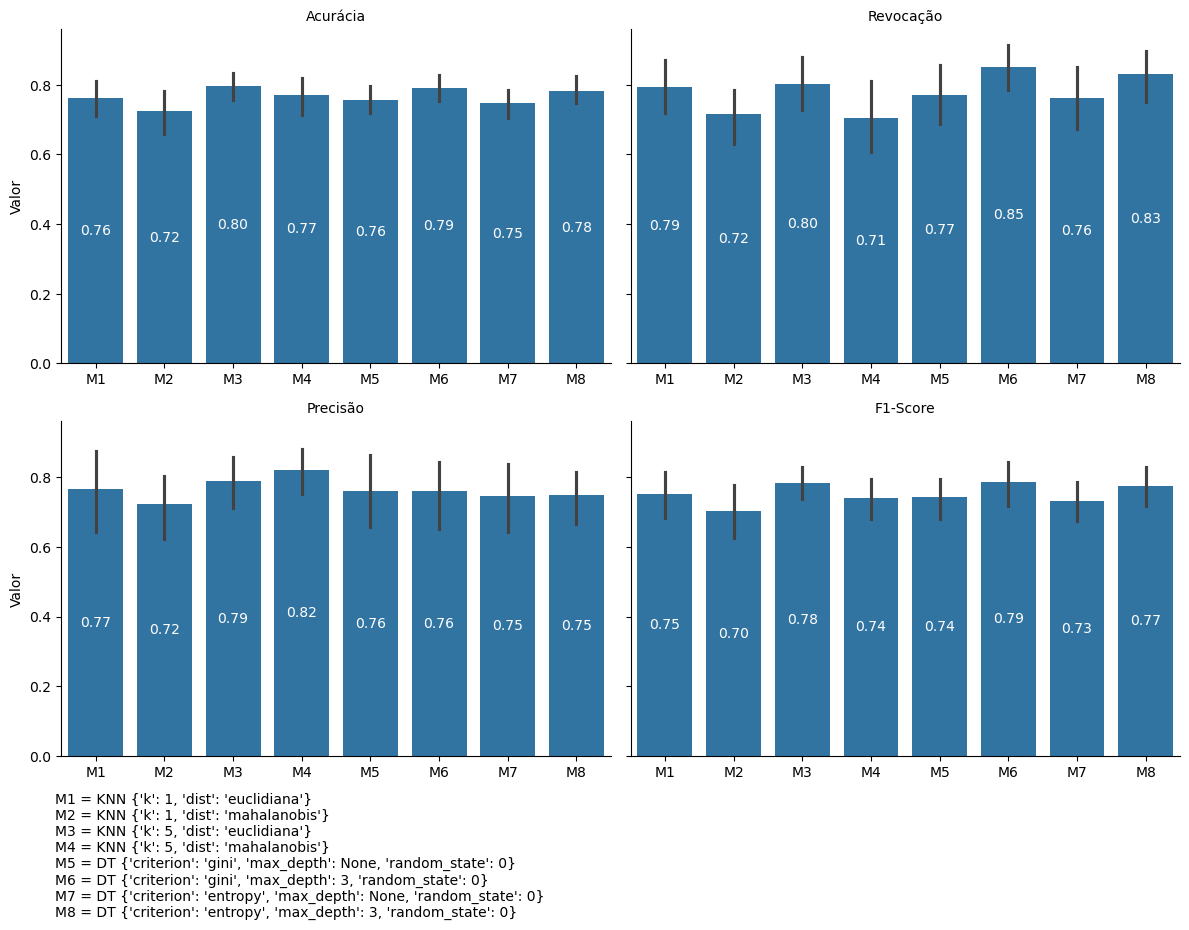

In [58]:
modelos_originais = [
    "KNN {'k': 1, 'dist': 'euclidiana'}",
    "KNN {'k': 1, 'dist': 'mahalanobis'}",
    "KNN {'k': 5, 'dist': 'euclidiana'}",
    "KNN {'k': 5, 'dist': 'mahalanobis'}",
    "DT {'criterion': 'gini', 'max_depth': None, 'random_state': 0}",
    "DT {'criterion': 'gini', 'max_depth': 3, 'random_state': 0}",
    "DT {'criterion': 'entropy', 'max_depth': None, 'random_state': 0}",
    "DT {'criterion': 'entropy', 'max_depth': 3, 'random_state': 0}",
]

modelos_codificados = {desc: f"M{i + 1}" for i, desc in enumerate(modelos_originais)}
resultados["modelo_codigo"] = resultados["parametros"].map(modelos_codificados)


def barplot_com_valores(data, x, y, **kwargs):
    ax = plt.gca()
    barplot = sns.barplot(data=data, x=x, y=y, ax=ax, **kwargs)
    for container in barplot.containers:
        barplot.bar_label(container, fmt="%.2f", label_type="center", color="white")


g = sns.FacetGrid(
    resultados,
    col="metricas",
    col_wrap=2,
    height=4,
    aspect=1.5,
    sharex=False,
    sharey=True,
)
g.map_dataframe(barplot_com_valores, x="modelo_codigo", y="value")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("", "Valor")
g.tight_layout()

legend_labels = [f"{cod} = {desc}" for desc, cod in modelos_codificados.items()]
legenda_texto = "\n".join(legend_labels)

plt.figtext(
    0.05, -0.15, legenda_texto, wrap=True, horizontalalignment="left", fontsize=10
)

plt.show()
